In [ ]:
# default_exp sparse.schedule

# Schedules

> When should I prune my network ?

In [ ]:
#export
import numpy as np

In [ ]:
#hide
import matplotlib.pyplot as plt
from fastai.vision.all import *

#%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

train = np.zeros(300)
prune = np.linspace(0,1, 700) 

In [ ]:
#hide 
def plot_sched(x, label):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5),linewidth=3)
    ax.plot(x, label=label, c='teal', linewidth=3)
    ax.set_xlabel('Training Iterations', fontsize=15)
    ax.set_ylabel('Sparsity', fontsize=15)    
    plt.tick_params(axis='x', labelsize=15, width=2)
    plt.tick_params(axis='y', labelsize=15, width=2)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.legend(prop={'size': 15})

## One-Shot

The easiest schedule is the one-shot pruning, i.e. prune the network once. This can be done by simply returning the desired sparsity value. The moment when you want to prune will be controlled by the `start_epoch` argument in the `SparsifyCallback`.

In [ ]:
#export
def one_shot(start, end, pos): return end

In [ ]:
#hide
os = [one_shot(0,50, p) for p in prune]

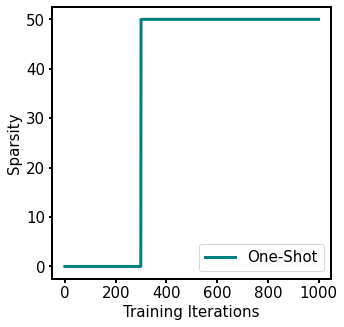

In [ ]:
plot_sched(np.concatenate([train, os]), label='One-Shot')

---

## Iterative

Instead of pruning the network to desired sparsity in one step, you can do it iteratively. In fasterai, you can change the amount of iterations

In [ ]:
#export
def iterative(start, end, pos, n_steps=3):
    "Perform iterative pruning, and pruning in `n_steps` steps"
    return start + ((end-start)/n_steps)*(np.ceil((pos)*n_steps))

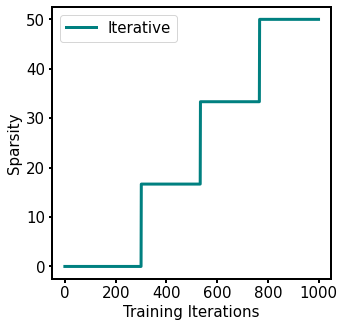

In [ ]:
plot_sched(np.concatenate([train, iterative(0,50, prune)]), label='Iterative')

To modify the default `n_steps`, you can use the `partial` function.

In [ ]:
iterative = partial(iterative, n_steps=5)

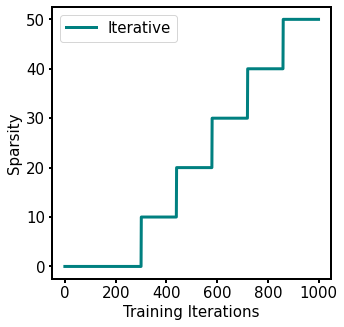

In [ ]:
plot_sched(np.concatenate([train, iterative(0,50, prune)]), label='Iterative')

---

## Automated Gradual Pruning

Some researchers have come up with more sophisticated schedules, such as the [Automated Gradual Pruning](https://arxiv.org/abs/1710.01878).

In [ ]:
#export
def sched_agp(start, end, pos): return end + start - end * (1 - pos)**3

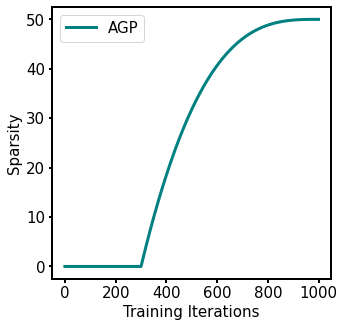

In [ ]:
plot_sched(np.concatenate([train, sched_agp(0,50, prune)]), label='AGP')

## One-Cycle Pruning

In [ ]:
#export
def sched_onecycle(start, end, pos, α=14, β=6):
    out = (1+np.exp(-α+β)) / (1 + (np.exp((-α*pos)+β)))
    return start + (end-start)*out

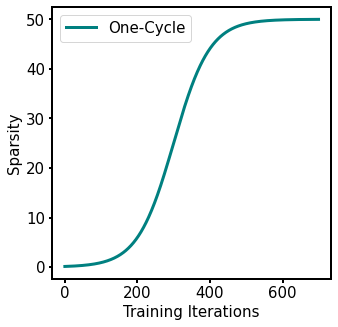

In [ ]:
plot_sched(sched_onecycle(0,50, prune), label='One-Cycle')

---

## Dense-Sparse-Dense

You can also create even more interesting behaviours such as the DSD method, where you prune the model in the first place, then re-grow it to its initial amount of parameter.

In [ ]:
def dsd(start, end, pos):
    if pos<0.5:
        return start + (1 + math.cos(math.pi*(1-pos*2))) * (end-start) / 2
    else:
        return end + (1 - math.cos(math.pi*(1-pos*2))) * (start-end) / 2

In [ ]:
#hide
dsd = [dsd(0,50, p) for p in prune]

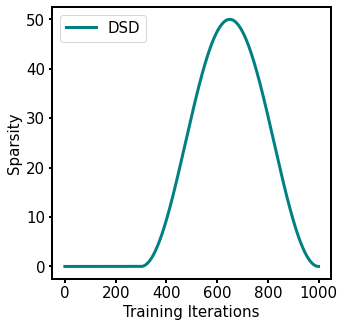

In [ ]:
plot_sched(np.concatenate([train, dsd]), label='DSD')